In [1]:
import jax
import jax.numpy as jnp
from ripplegw.constants import gt, m_per_Mpc, PI, TWO_PI, MRSUN, C
from ripplegw.waveforms.IMRPhenomXAS_NRTidalv3 import gen_IMRPhenomXAS_NRTidalv3_hphc, gen_IMRPhenomXAS_NRTidalv3
from ripplegw import ms_to_Mc_eta, lambdas_to_lambda_tildes, get_eff_pads, get_match_arr

import lalsimulation as lalsim
import lal
import numpy as np

import matplotlib.pyplot as plt

/home/robinc/anaconda3/envs/jim_dev_env/lib/python3.12/site-packages/lalsimulation/lalsimulation.py:8: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal


In [2]:
# Frequency grid
T = 128
f_l = 20.0
f_sampling = 2 * 4096
f_u = f_sampling // 2
f_ref = f_l

delta_t = 1 / f_sampling
tlen = int(round(T / delta_t))
freqs = np.fft.rfftfreq(tlen, delta_t)
df = freqs[1] - freqs[0]
fs = freqs[(freqs > f_l) & (freqs < f_u)]

In [3]:
m1 = 1.37 # In solar masses
m2 = 1.37
chi1 = 0.141 # Dimensionless spin
chi2 = 0.141
lambda1 = 1001.8
lambda2 = 1001.8
tc = 0.0 # Time of coalescence in seconds
phic = 0.0 # Time of coalescence
dist_mpc = 440 # Distance to source in Mpc
inclination = 0.0 # Inclination Angle

q = m1/m2
Mc, eta = ms_to_Mc_eta(jnp.array([m1, m2]))
lambda_tilde, delta_lambda_tilde = lambdas_to_lambda_tildes(
    jnp.array([lambda1, lambda2, m1, m2])
)

theta_ripple = jnp.array(
    [
        Mc,
        eta,
        chi1,
        chi2,
        lambda_tilde,
        delta_lambda_tilde,
        dist_mpc,
        tc,
        phic,
        inclination,
    ]
)
fs_ripple = jnp.arange(f_l, f_u, df)[1:]

In [4]:
from ripplegw.waveforms.NRTidalv3_utils import _get_merger_frequency, get_tidal_phase, get_NRTidalv3_coefficients, get_tidalphasePN_coeffs, get_tidal_phase_PN, general_planck_taper
from ripplegw.waveforms.IMRPhenomD_NRTidalv2 import get_planck_taper, get_tidal_amplitude, get_spin_phase_correction
from ripplegw.waveforms.IMRPhenomXAS import gen_IMRPhenomXAS_hphc
from ripplegw.waveforms.IMRPhenom_tidal_utils import get_kappa

## Some inital sanity checks:

### Merger frequency

In [5]:
theta_intrinsic = jnp.array([m1, m2, chi1, chi2, lambda1, lambda2])
M = m1 + m2
Xa = m1/M
f_merger_ripple = _get_merger_frequency(theta_intrinsic)
print(f_merger_ripple)
f_merger_LAL = lalsim.SimNRTunedTidesMergerFrequency_v3(M, lambda1, lambda2, q, chi1, chi2)
print(f_merger_LAL)

1623.969
1623.9690632395718


### Tidal phase components

In [6]:
PN_coeffs = get_tidalphasePN_coeffs(theta_intrinsic)
NRTidalv3_coeffs = get_NRTidalv3_coefficients(theta_intrinsic, PN_coeffs)

M_s = M * gt
M_omega = (PI * M_s * fs_ripple)
P_P = general_planck_taper(fs, 1.15*f_merger_ripple, 1.35*f_merger_ripple)

kappa = get_kappa(jnp.array([m1,m2,chi1,chi2,lambda1,lambda2]))
tidal_amp = get_tidal_amplitude(M_omega**(2/3), theta_intrinsic, kappa, distance=dist_mpc)

tidal_phase = get_tidal_phase(M_omega, NRTidalv3_coeffs, PN_coeffs)
tidal_phasePN = get_tidal_phase_PN(M_omega, Xa, lambda1, lambda2, PN_coeffs)
tidal_phase_corr = tidal_phase * (1 - P_P) + tidal_phasePN * P_P

The following cells are a test for the local minimum of the tidal phase. It doesn't work yet, so don't pay too much attention to it

In [7]:
increasing = jnp.concatenate([jnp.array([False]), tidal_phase[1:] >= tidal_phase[:-1]])
fHzmrgcheck = 0.9*f_merger_ripple
# Apply fHz threshold
valid = (fs >= fHzmrgcheck) & increasing
print(valid)
first_valid = jnp.argmax(valid)  # returns 0 if none are True
print(first_valid)
found = jnp.any(valid)
print(found)
tidal_min_value = jnp.where(found, tidal_phase[first_valid - 1], 0.0)

# Build mask for indices after that point
mask = (jnp.arange(fs.size) > (first_valid - 1)) & found
print(mask)
phi_tidal = jnp.where(mask, tidal_min_value, tidal_phase)

[False False False ... False  True False]
215839
True
[False False False ...  True  True  True]


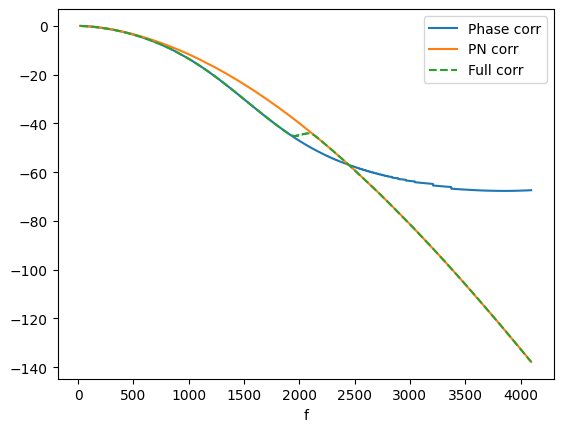

In [8]:
plt.plot(fs, tidal_phase,label='Phase corr')
plt.plot(fs, tidal_phasePN,label='PN corr')
plt.plot(fs, tidal_phase_corr, ls='--',label='Full corr')
plt.legend()
plt.xlabel('f')
# plt.xscale('log')
plt.show()

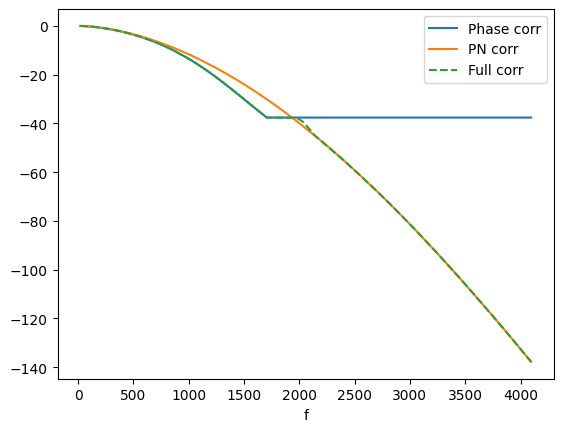

In [9]:
tidal_phase_corr_withMIN = phi_tidal * (1 - P_P) + tidal_phasePN * P_P
plt.plot(fs, phi_tidal,label='Phase corr')
plt.plot(fs, tidal_phasePN,label='PN corr')
plt.plot(fs, tidal_phase_corr_withMIN, ls='--',label='Full corr')
plt.legend()
plt.xlabel('f')
# plt.xscale('log')
plt.show()

In [10]:
laldict = lal.CreateDict()
lalsim.SimInspiralWaveformParamsInsertTidalLambda1(laldict, lambda1)
lalsim.SimInspiralWaveformParamsInsertTidalLambda2(laldict, lambda2)
quad1 = lalsim.SimUniversalRelationQuadMonVSlambda2Tidal(lambda1)
quad2 = lalsim.SimUniversalRelationQuadMonVSlambda2Tidal(lambda2)
# print(quad1)
oct1 = lalsim.SimUniversalRelationSpinInducedOctupoleVSSpinInducedQuadrupole(quad1)
oct2 = lalsim.SimUniversalRelationSpinInducedOctupoleVSSpinInducedQuadrupole(quad2)
# print(oct1)
lalsim.SimInspiralWaveformParamsInsertdQuadMon1(laldict, quad1 - 1)
lalsim.SimInspiralWaveformParamsInsertdQuadMon2(laldict, quad2 - 1)

IMRphenom = "IMRPhenomXAS_NRTidalv3"
approximant = lalsim.SimInspiralGetApproximantFromString(IMRphenom)

theta = np.array(
    [m1, m2, chi1, chi2, lambda1, lambda2, dist_mpc, tc, phic, inclination]
)

m1_kg = theta[0] * lal.MSUN_SI
m2_kg = theta[1] * lal.MSUN_SI
distance = dist_mpc * 1e6 * lal.PC_SI

ph_tdLAL = np.zeros(fs.shape)
amp_tdLAL = np.zeros(fs.shape)
pl_taperLAL = np.zeros(fs.shape)

lalsim.SimNRTunedTidesFDTidalPhaseFrequencySeries(
    phi_tidal=ph_tdLAL,
    amp_tidal=amp_tdLAL,
    planck_taper=pl_taperLAL,
    fHz=fs,
    m1_SI=m1_kg,
    m2_SI=m2_kg,
    lambda1=lambda1,
    lambda2=lambda2,
    chi1=chi1,
    chi2=chi2,
    NRTidal_version=lalsim.NRTidalv3_V
)

0

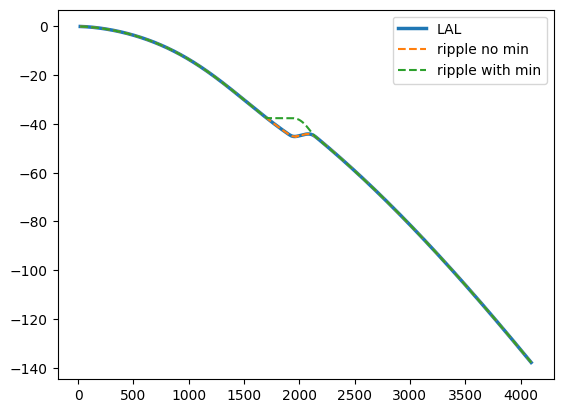

In [11]:
plt.plot(fs, ph_tdLAL, label='LAL', lw=2.5)
plt.plot(fs, tidal_phase_corr, label='ripple no min', ls='--')
plt.plot(fs, tidal_phase_corr_withMIN, label='ripple with min', ls='--')
# plt.axvline(fs[first_valid], min(ph_tdLAL), max(ph_tdLAL), c='r', ls='-.', alpha=0.7)S
plt.legend()
plt.show()

### NRTidal phase component
(not spin!)

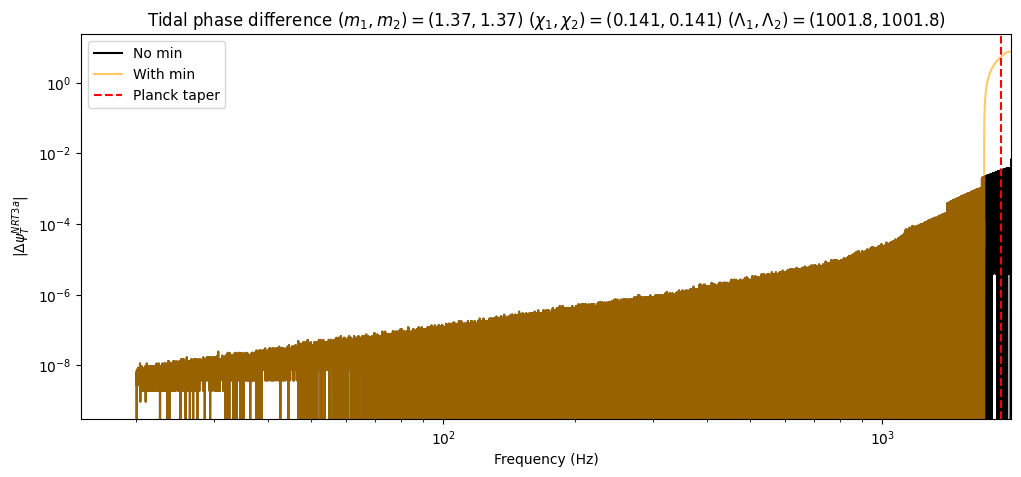

In [12]:
plt.figure(figsize=(12, 5))
delta_psi_tidal = ph_tdLAL - tidal_phase_corr
delta_psi_tidal_withMIN = ph_tdLAL - tidal_phase_corr_withMIN
plt.plot(fs, abs(delta_psi_tidal), "-", color="black", label='No min')
plt.plot(fs, abs(delta_psi_tidal_withMIN), "-", color="orange", alpha=0.6, label='With min')
plt.axvline(1.15 * f_merger_ripple, linestyle="--", color="r", label="Planck taper")
plt.axvline(1.35 * f_merger_ripple, linestyle="--", color="r")
plt.legend()
plt.title(
    r"Tidal phase difference ($m_1, m_2) = ({}, {}$) ($\chi_1, \chi_2) = ({}, {}$) ($\Lambda_1, \Lambda_2) = ({}, {}$)".format(
        m1, m2, chi1, chi2, lambda1, lambda2
    )
)
plt.xlabel("Frequency (Hz)")
plt.ylabel(r"$|\Delta \psi^{NRT3a}_T|$")
plt.xscale("log")
plt.xlim(f_l - 5, 1.2 * f_merger_ripple + 20)
plt.yscale("log")
plt.show()

### $\kappa^{2T}$ check

In [13]:
kappa_LAL = lalsim.SimNRTunedTidesComputeKappa2T(m1_kg, m2_kg, lambda1, lambda2)
print(kappa_LAL)
print(kappa)

187.8375
187.8375


In [14]:
# Ripple waveform generation
hp_ripple, hc_ripple = gen_IMRPhenomXAS_NRTidalv3_hphc(
    fs_ripple, theta_ripple, f_ref
)
hp_ripple

Array([ 5.5581057e-24-2.7243789e-24j,  8.2296243e-25+6.1320864e-24j,
       -6.0873832e-24-1.0901924e-24j, ...,  0.0000000e+00+0.0000000e+00j,
        0.0000000e+00+0.0000000e+00j,  0.0000000e+00+0.0000000e+00j],      dtype=complex64)

In [15]:
hp, _ = lalsim.SimInspiralChooseFDWaveform(
    m1_kg,
    m2_kg,
    0.0,
    0.0,
    chi1,
    0.0,
    0.0,
    chi2,
    distance,
    inclination,
    phic,
    0,
    0,
    0,
    df,
    f_l,
    f_u,
    f_ref,
    laldict,
    approximant,
)

approximantXAS = lalsim.SimInspiralGetApproximantFromString("IMRphenomXAS")
laldictXAS = lal.CreateDict()
hpXAS, _ = lalsim.SimInspiralChooseFDWaveform(
    m1_kg,
    m2_kg,
    0.0,
    0.0,
    chi1,
    0.0,
    0.0,
    chi2,
    distance,
    inclination,
    phic,
    0,
    0,
    0,
    df,
    f_l,
    f_u,
    f_ref,
    laldictXAS,
    approximantXAS,
)

freqs_lal = np.arange(len(hp.data.data)) * df

mask_lal = (freqs_lal > f_l) & (freqs_lal < f_u)
hp_lalsuite = hp.data.data[mask_lal]
hpXAS_lalsuite = hpXAS.data.data[mask_lal]

In [16]:
f = freqs_lal[mask_lal]

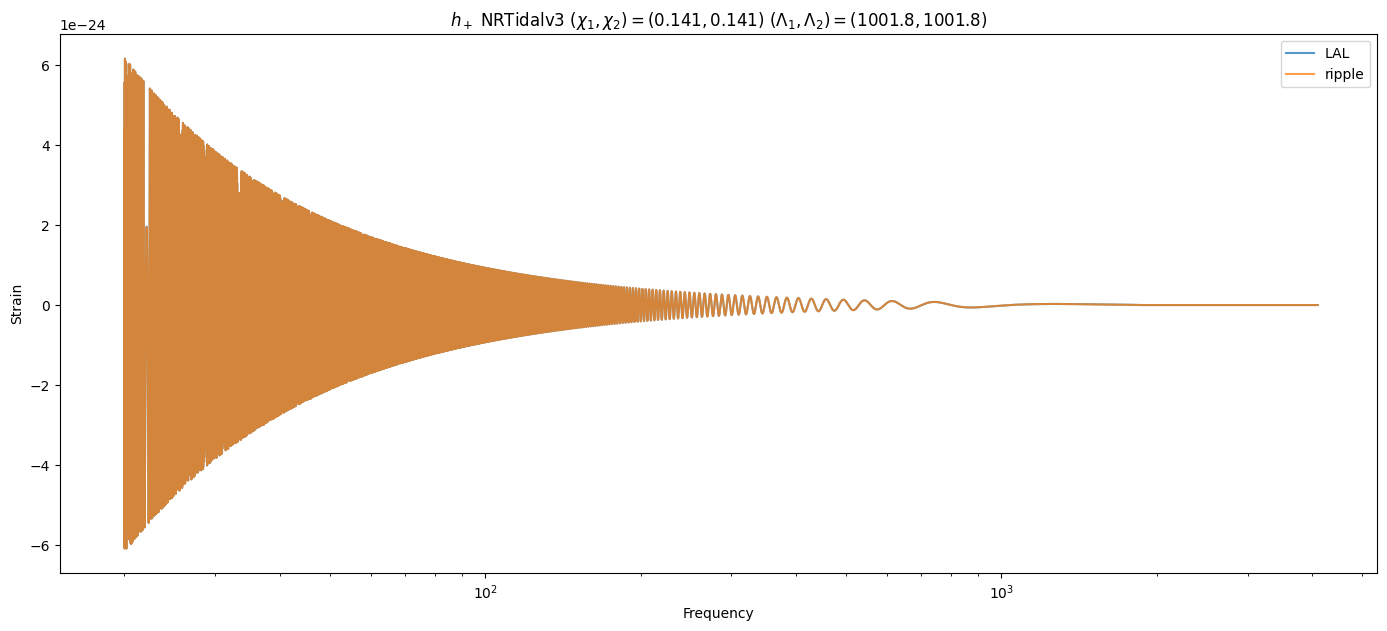

In [17]:
a = 0.75
plt.subplots(1, 1, figsize=(17, 7))
# plt.subplot(1, 2, 1)

plt.plot(f, hp_lalsuite.real, "-", label="LAL", alpha=a)
plt.plot(f, hp_ripple.real, "-", label="ripple", alpha=a)
# plt.plot(fs, hpXAS_lalsuite.real, label="LAL XAS", alpha=a)
plt.title(f"h+, NRTidalv3 lambda1, lambda2 = {lambda1, lambda2}")
plt.title(
    r"$h_+$ NRTidalv3 ($\chi_1, \chi_2) = ({}, {}$) ($\Lambda_1, \Lambda_2) = ({}, {}$)".format(chi1,chi2,lambda1, lambda2)
)
plt.xlabel("Frequency")
plt.ylabel("Strain")
plt.xscale("log")
plt.xlim(f_l - 5)
plt.legend()
plt.show()

In [18]:
print(hp_ripple)
print(hp_lalsuite)

[ 5.5581057e-24-2.7243789e-24j  8.2296243e-25+6.1320864e-24j
 -6.0873832e-24-1.0901924e-24j ...  0.0000000e+00+0.0000000e+00j
  0.0000000e+00+0.0000000e+00j  0.0000000e+00+0.0000000e+00j]
[ 5.55985471e-24-2.72080888e-24j  8.22331359e-25+6.13217153e-24j
 -6.08430890e-24-1.10723009e-24j ...  0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j]


In [19]:
psd_file = "psds/psd.txt"
f_ASD, ASD = np.loadtxt(psd_file, unpack=True)
ASD = np.sqrt(ASD)

ASD_vals = np.interp(fs, f_ASD, ASD)
PSD_vals = ASD_vals**2
pad_low, pad_high = get_eff_pads(fs)
# match = get_match_arr(
#         pad_low,
#         pad_high,
#         PSD_vals,
#         hp_ripple,
#         hp_lalsuite,
#         )

h1s = hp_ripple
h2s = hp_lalsuite

norm1 = jnp.sqrt(jnp.sum((jnp.abs(h1s)/ASD_vals)**2))
norm2 = jnp.sqrt(jnp.sum((jnp.abs(h2s)/ASD_vals)**2))

print(norm1)
print(norm2)
# Use IFFT trick to maximize over t_c. Ref: Maggiore's book, eq. 7.171.
integrand_padded = jnp.concatenate((pad_low, h1s.conj() * h2s / PSD_vals, pad_high))
match = jnp.abs(len(integrand_padded) * jnp.fft.ifft(integrand_padded)).max() / (norm1 * norm2)

print(match)

43.136898
43.13691
nan


## Check total amplitude and phase

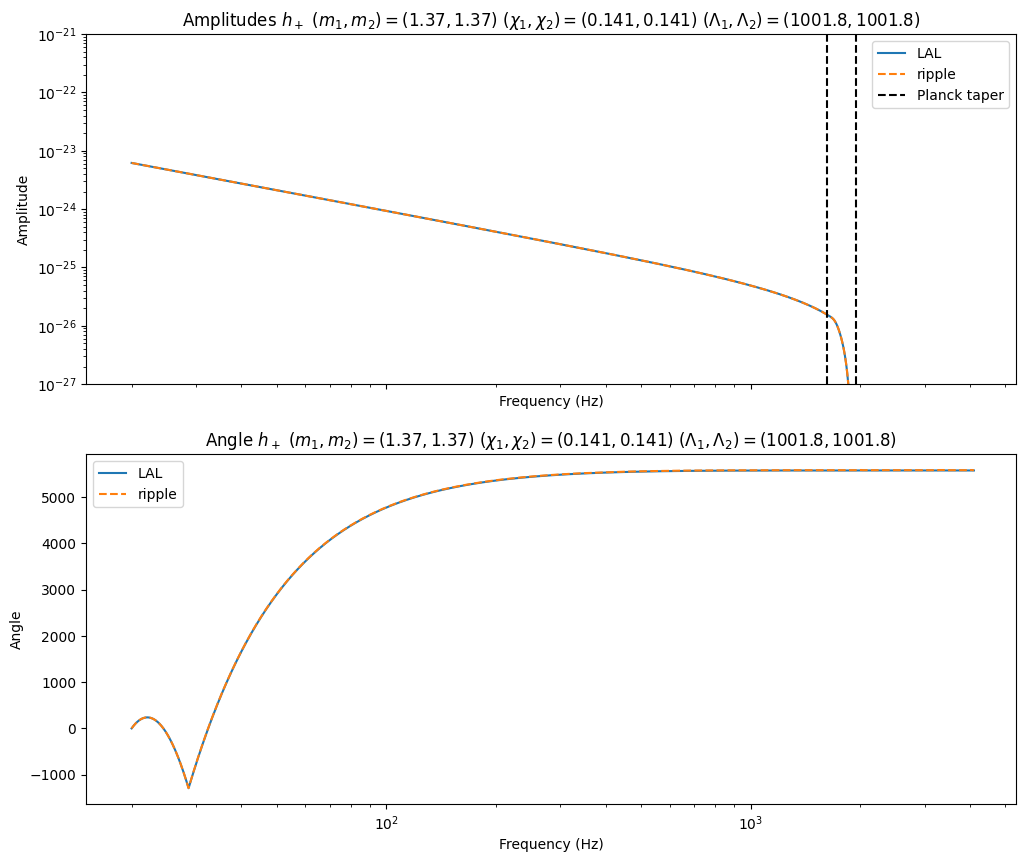

In [20]:
## Get the merger frequency to check the Planck taper window

l1, l2 = lambda1, lambda2
merger_params = jnp.array([m1, m2, chi1, chi2, l1, l2])

f_merger = f_merger_ripple
f_merger = float(f_merger)

## Get amplitude and angle for comparison

A_lalsuite = jnp.abs(hp_lalsuite)
angle_lalsuite = np.unwrap(np.angle(hp_lalsuite))
phase_lalsuite = hp_lalsuite / A_lalsuite

A_ripple = jnp.abs(hp_ripple)
angle_ripple = np.unwrap(np.angle(hp_ripple))
phase_ripple = hp_ripple / A_ripple

# Choose whether we plot the angle or the phase
plot_angle = True

plt.subplots(2, 1, figsize=(12, 10), sharex=True)
plt.subplot(2, 1, 1)

# Plot the amplitude
plt.plot(freqs_lal[mask_lal], A_lalsuite, "-", label="LAL")
plt.plot(fs_ripple, A_ripple, "--", label="ripple")

# Plot where the Planck taper has to take place
plt.axvline(f_merger, linestyle="--", color="black", label="Planck taper")
plt.axvline(1.2 * f_merger, linestyle="--", color="black")

plt.title(
    r"Amplitudes $h_+$ ($m_1, m_2) = ({}, {}$) ($\chi_1, \chi_2) = ({}, {}$) ($\Lambda_1, \Lambda_2) = ({}, {}$)".format(
        m1, m2, chi1, chi2, lambda1, lambda2
    )
)
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.ylim(1e-27, 1e-21)
plt.xlim(f_l - 5)
plt.legend()

# Plot the angle or the phase
plt.subplot(2, 1, 2)
if plot_angle:
    plt.plot(freqs_lal[mask_lal], angle_lalsuite, "-", label="LAL")
    plt.plot(fs_ripple, angle_ripple, "--", label="ripple")
    name = "Angle"
else:
    plt.plot(freqs_lal[mask_lal], phase_lalsuite, "-", label="LAL")
    plt.plot(fs_ripple, phase_ripple, "--", label="ripple")
    name = "Phase"
plt.legend()
plt.title(
    r"{} $h_+$ ($m_1, m_2) = ({}, {}$) ($\chi_1, \chi_2) = ({}, {}$) ($\Lambda_1, \Lambda_2) = ({}, {}$)".format(
        name, m1, m2, chi1, chi2, lambda1, lambda2
    )
)
plt.xlabel("Frequency (Hz)")
plt.ylabel(f"{name}")
plt.xscale("log")
plt.xlim(f_l - 5)
plt.show()

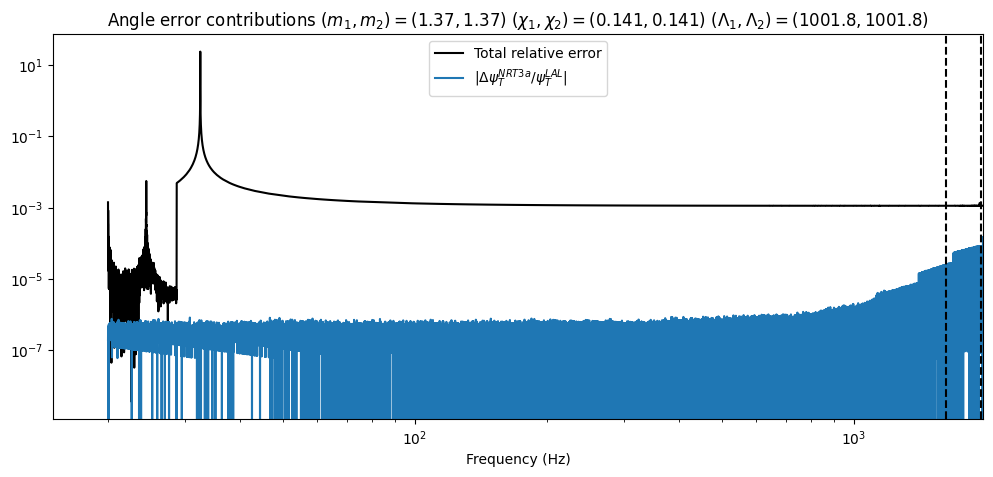

In [21]:
plt.figure(figsize=(12, 5))
plt.plot(f, abs((angle_lalsuite - angle_ripple)/angle_lalsuite), "-", color="black", label='Total relative error')
plt.plot(fs, abs(delta_psi_tidal/ph_tdLAL), "-", label=r"$|\Delta \psi^{NRT3a}_T / \psi_T^{LAL}|$")
plt.legend()
plt.title(
    r"Angle error contributions ($m_1, m_2) = ({}, {}$) ($\chi_1, \chi_2) = ({}, {}$) ($\Lambda_1, \Lambda_2) = ({}, {}$)".format(
        m1, m2, chi1, chi2, lambda1, lambda2
    )
)
plt.yscale('log')
plt.axvline(f_merger, linestyle="--", color="black", label="Planck taper")
plt.axvline(1.2 * f_merger, linestyle="--", color="black")
plt.xlabel("Frequency (Hz)")
plt.xscale("log")
plt.xlim(f_l - 5, 1.2 * f_merger + 20)
plt.show()

In [22]:
Xb = 1-Xa
SS_3p5PN, SSS_3p5PN = lalsim.SimInspiralGetHOSpinTerms(
    Xa,
    Xb,
    chi1,
    chi2,
    quad1,
    quad2
)

SS_3p5PN *= 3.*M_omega**(2/3)/(128.*eta)
SSS_3p5PN *= 3.*M_omega**(2/3)/(128.*eta)

## Phase Checks
Let's extract the BBH phase after it has been aligned with the tidal corrections, but no global tidal corrections have been made. So only the alignment has been corrected. This is something we can extract from LAL

In [23]:
laldict_OnlyPhase = lal.CreateDict()
lalsim.SimInspiralWaveformParamsInsertTidalLambda1(laldict_OnlyPhase, lambda1)
lalsim.SimInspiralWaveformParamsInsertTidalLambda2(laldict_OnlyPhase, lambda2)
quad1 = lalsim.SimUniversalRelationQuadMonVSlambda2Tidal(lambda1)
quad2 = lalsim.SimUniversalRelationQuadMonVSlambda2Tidal(lambda2)
# print(quad1)
oct1 = lalsim.SimUniversalRelationSpinInducedOctupoleVSSpinInducedQuadrupole(quad1)
oct2 = lalsim.SimUniversalRelationSpinInducedOctupoleVSSpinInducedQuadrupole(quad2)
# print(oct1)
lalsim.SimInspiralWaveformParamsInsertdQuadMon1(laldict_OnlyPhase, quad1 - 1)
lalsim.SimInspiralWaveformParamsInsertdQuadMon2(laldict_OnlyPhase, quad2 - 1)

# Specify we only want phase contribution (before LAL adds tidal and spin phase terms)
lalsim.SimInspiralWaveformParamsInsertPhenomXOnlyReturnPhase(laldict_OnlyPhase, 1)

phaseLAL = lalsim.SimIMRPhenomXASGenerateFD(
    m1_kg,
    m2_kg,
    chi1,
    chi2,
    distance,
    f_l,
    f_u,
    df,
    phic,
    f_ref,
    laldict_OnlyPhase,
)

phaseLAL = phaseLAL.data.data[mask_lal]

h22 = lalsim.SimIMRPhenomXASGenerateFD(
    m1_kg,
    m2_kg,
    chi1,
    chi2,
    distance,
    f_l,
    f_u,
    df,
    phic,
    f_ref,
    laldict,
)

h22 = h22.data.data[mask_lal]

In [24]:
psi_bbh, phase_shift, phifRef, phiTfRef, dphiXAS, dphiT, dphi_merger, psi_T, psi_SS = gen_IMRPhenomXAS_NRTidalv3(f, theta_ripple, f_ref, get_phase=True)

In [25]:
print(dphiXAS)
print(dphiT)

0.0024134202
-0.036544297


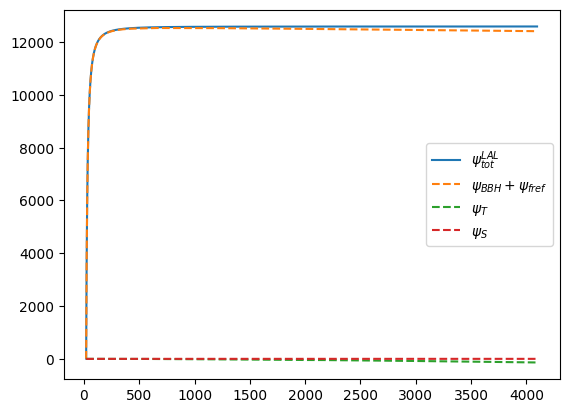

In [26]:
plt.plot(f, phaseLAL.real, label=r'$\psi_{tot}^{LAL}$')
plt.plot(f, psi_bbh + phase_shift, ls='--', label=r'$\psi_{BBH} + \psi_{fref}$')
# plt.plot(f, phase_shift, ls='--', label=r'$\psi_{fref}$')
plt.plot(f, psi_T, ls='--', label=r'$\psi_T$')
plt.plot(f, psi_SS, ls='--', label=r'$\psi_S$')
plt.legend()
# plt.xscale('log')
# plt.yscale('log')
plt.show()

$\psi_T$ won't play a role here as this is not extracted from LAL. Let's look further into the difference between the tidal-aligned BBH baselines

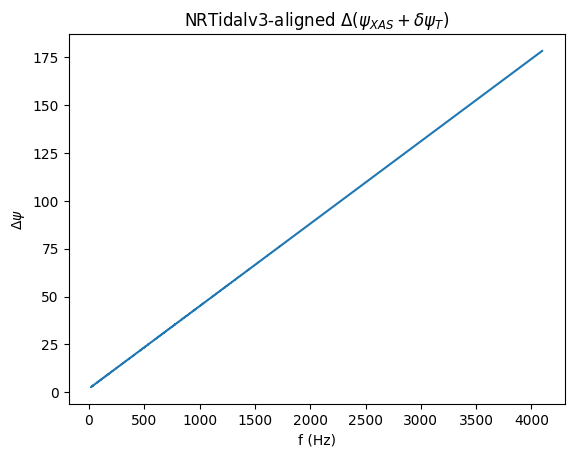

In [27]:
plt.plot(f, (phaseLAL.real - (psi_bbh + phase_shift)))
# plt.xscale('log')
# plt.yscale('log')
plt.title(r'NRTidalv3-aligned $\Delta (\psi_{XAS} + \delta \psi_{T})$')
plt.ylabel(r'$\Delta \psi$')
plt.xlabel('f (Hz)')
plt.show()

This error increases linearly with frequency. The only term that scales linearly with frequency in the tidal-aligned baseline is linb*Mf (line 840 in LALSimIMRPhenomX.c). So this is probably where the alignment error lies.

Currently, the phase that we get from **LAL** consists of the non-algned XAS BBH baseline + the tidal alignment:
$$\psi^{LAL} = \psi_{XAS}(f) - [\psi_{XAS}(f_{ref}) - \psi_T(f_{ref}) - d\psi_{XAS}(f_{ref}) M_s f_{ref} + d\psi_T(f_{ref}) M_s f_{ref}] + 2\psi_0 + \frac{\pi}{4} + b M_s f$$
where $M_s$ is the total mass of the system in seconds. *If I am not mistaken*, b should be given by: $-(d\psi_{XAS}(f_{ref}) - d\psi_T(f_{ref}))$ (see lines 737-739 of LALSimIMRPhenomX.c)

Considering the ripple and LAL XAS baselines agree well, we can use the non-phase-aligned ripple XAS phase to remove this baseline and directly compare the ripple and LAL tidal alignment corrections.

In [28]:
from ripplegw.waveforms.IMRPhenomXAS import Phase
from ripplegw.waveforms.IMRPhenomX_utils import PhenomX_phase_coeff_table as bbh_phase_coeffs
from ripplegw.waveforms import IMRPhenomX_utils
from ripplegw.waveforms.IMRPhenomXAS_NRTidalv3 import fullTidalPhaseCorrection

In [29]:
ripple_XAS_phase = Phase(f, jnp.array([m1,m2,chi1,chi2]), bbh_phase_coeffs)
LAL_phase_offset = phaseLAL.real - ripple_XAS_phase # Should consist of linb*Mf + lina(=0) + phifRef (LAL!!)

# b * M * (f - f_ref) = \Delta\psi + phifRef(ripple) - phiTfRef
bMf_min_fref = LAL_phase_offset + phifRef - phiTfRef # phiTfRef is defined with opposite sign from LAL

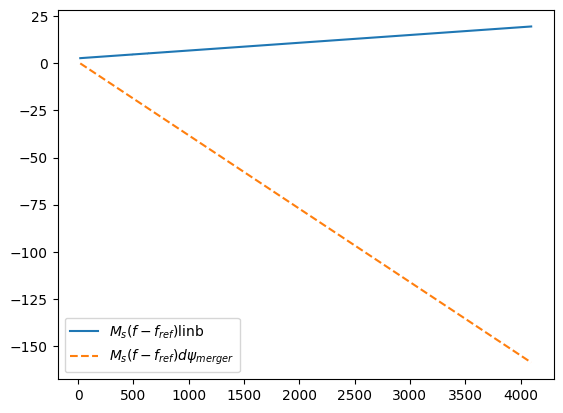

In [30]:
plt.plot(f, bMf_min_fref, label=r'$M_s(f-f_{ref})\text{linb}$')
plt.plot(f, dphi_merger*M_s*(f - f_ref), ls='--', label=r'$M_s(f-f_{ref})d\psi_{merger}$')
plt.legend()
# plt.yscale('log')
# plt.xscale('log')
plt.show()

This is good enough for now